In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
def read_data(filepath):
    df = pd.read_csv(filepath)
    df = df.groupby(['source','target'], as_index=False).mean()
    df['value'] = df['value']*2
    df['unique'] = df.apply(lambda x: True if x['source'] != x['target'] else False, axis=1)
   # df = df[df['unique'] == True]
    return df



In [3]:
def create_graph(df, val_col = "value"):
    G = nx.DiGraph()
    for k in df.iterrows():
        source = k[1]['source']
        value = k[1][val_col]
        source_layer = k[1]['source layer']+1
        G.add_node(source, weight=value, layer=source_layer)
    for k in df.iterrows():
        source = k[1]['source']
        target = k[1]['target']
        G.add_edge(source, target)
    root_layer = max(df['target layer'])+1
    G.add_node('root', weight=0, layer = root_layer)
    return G



In [4]:
def get_downstream_subgraph(G, query_node, depth_limit=None):
    SG = nx.DiGraph()
    nodes = [n for n in nx.traversal.bfs_successors(G, query_node,depth_limit=depth_limit ) if n != query_node]
    for source, targets in nodes:
        SG.add_node(source, **G.nodes()[source])
        for t in targets:
            SG.add_node(t, **G.nodes()[t])
    for node1 in SG.nodes():
        for node2 in SG.nodes():
            if G.has_edge(node1,node2):
                SG.add_edge(node1,node2)
                
    SG.add_node(query_node, **G.nodes()[query_node])
    return SG

def get_upstream_subgraph(G, query_node,depth_limit=None):
    G = G.reverse()
    SG = get_downstream_subgraph(G, query_node, depth_limit=depth_limit)
    return SG
    
def get_complete_subgraph(G, query_node, depth_limit=None):
    SG = get_downstream_subgraph(G, query_node)
    G = G.reverse()
    nodes = [n for n in nx.traversal.bfs_successors(G, query_node, depth_limit=depth_limit) if n != query_node]
    for source, targets in nodes:
        SG.add_node(source, **G.nodes()[source])
        for t in targets:
            SG.add_node(t, **G.nodes()[t])
    for node1 in SG.nodes():
        for node2 in SG.nodes():
            if G.has_edge(node1,node2):
                SG.add_edge(node1,node2)
            
    SG.add_node(query_node, **G.nodes()[query_node])
    return SG


In [5]:
def get_nr_nodes_in_SG(G, query_node): 
    nr_nodes = 0
    SG= get_complete_subgraph(G, query_node, depth_limit=None)
    for node in SG.nodes():
        nr_nodes += 1
    return nr_nodes

def get_conn_in_last_layer(G,query_node):
    nr_nodes = 0
    SG= get_complete_subgraph(G, query_node, depth_limit=None)
    layers = [SG.nodes()[n]['layer'] for n in SG.nodes()]
    last_layer = list(set(layers))[-2]
    for node in [n for n in SG.nodes() if SG.nodes()[n]['layer'] == last_layer]:
        nr_nodes += 1
    return nr_nodes
    
def get_fan_in(G, query_node):
    return len([n for n in G.in_edges(query_node)])

def get_fan_out(G, query_node):
    return len([n for n in G.out_edges(query_node)])

def add_normalization(df,G):
    df['fan_in'] = df.apply(lambda x: get_fan_in(G, x['source']), axis=1)
    df['fan_out'] = df.apply(lambda x: get_fan_out(G,x['source']), axis=1)
    df['fan_tot'] = df.apply(lambda x: x['fan_in'] + x['fan_out'], axis=1)
    df['nodes_in_SG'] = df.apply(lambda x: get_nr_nodes_in_SG(G, x['source']), axis=1)
    df['log(Nodes in SG)'] = np.log2(df['nodes_in_SG'])
    df['weighted_val_log'] = df.apply(lambda x: x["value"]/(1+np.log2( x['nodes_in_SG']) if x['nodes_in_SG'] > 0 else x['value']), axis=1)
    return df

In [6]:
from ShapExplainerUtil import shap_sankey
from plotly.offline import init_notebook_mode
import plotly

data = "sepsis"
filepath = f'../../plots/manuscript/SHAP/less_epochs/20_residual_ShapConnections_{data}.csv'
df = read_data(filepath)
G = create_graph(df)
df = add_normalization(df,G)
df.head()

,source,target,Unnamed: 0,value,type,source layer,target layer,normalized value,unique,fan_in,fan_out,fan_tot,nodes_in_SG,log(Nodes in SG),weighted_val_log
0,1433B,Activation of BH3-only proteins,3570.5,0.000495,0.5,0.0,1.0,0.000271,True,0,21,21,51,5.672425,0.000074
1,1433B,Butyrate Response Factor 1 (BRF1) binds and de...,3608.5,0.000495,0.5,0.0,1.0,0.000271,True,0,21,21,51,5.672425,0.000074
2,1433B,FOXO-mediated transcription,3578.5,0.000495,0.5,0.0,1.0,0.000271,True,0,21,21,51,5.672425,0.000074
3,1433B,G2/M DNA damage checkpoint,3596.5,0.000495,0.5,0.0,1.0,0.000271,True,0,21,21,51,5.672425,0.000074
4,1433B,Paradoxical activation of RAF signaling by kin...,3590.5,0.000495,0.5,0.0,1.0,0.000271,True,0,21,21,51,5.672425,0.000074


In [6]:
def generate_sankey(df, G, query_node, upstream=False, save=False, val_col='value'):
    if upstream == False:
        final_node = "root"
        SG = get_downstream_subgraph(G, query_node, depth_limit=None)
        source_or_target = "source" 
    else:
        final_node = query_node
        SG = get_upstream_subgraph(G, query_node, depth_limit=None)
        source_or_target = "target"      
    layer_1_nodes = [n for n in SG.nodes() if SG.nodes()[n]['layer'] == 1]

    important = [SG.nodes()[n]['weight'] for n in layer_1_nodes]
    init_notebook_mode(connected = True)
    nodes_in_SG = [n for n in SG.nodes] 
    df = df[df[source_or_target].isin(nodes_in_SG)]
    fig = shap_sankey(df, final_node = final_node, val_col = val_col)
    if save:
        fig.write_image(f'../../plots/manuscript/network/{data}_sankey_{query_node}.svg', width=1200, scale=2.5, height=800)
    fig.show()

In [7]:
from ShapExplainerUtil import shap_sankey
from plotly.offline import init_notebook_mode
import plotly
data = "sepsis"
filepath = f'../../plots/manuscript/network/{data}_processed.csv'
df = pd.read_csv(filepath)
val_col = "weighted_val_log"
query_node = "CD14"
upstream = False
save = True
G = create_graph(df, val_col=val_col)
generate_sankey(df, G, query_node, upstream, save, val_col)

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Not found:  MyD88 deficiency (TLR2/4)
Not found:  Antigen processing-Cross presentation
Not found:  IRAK4 deficiency (TLR2/4)
Not found:  Diseases of Immune System
Not found:  Programmed Cell Death


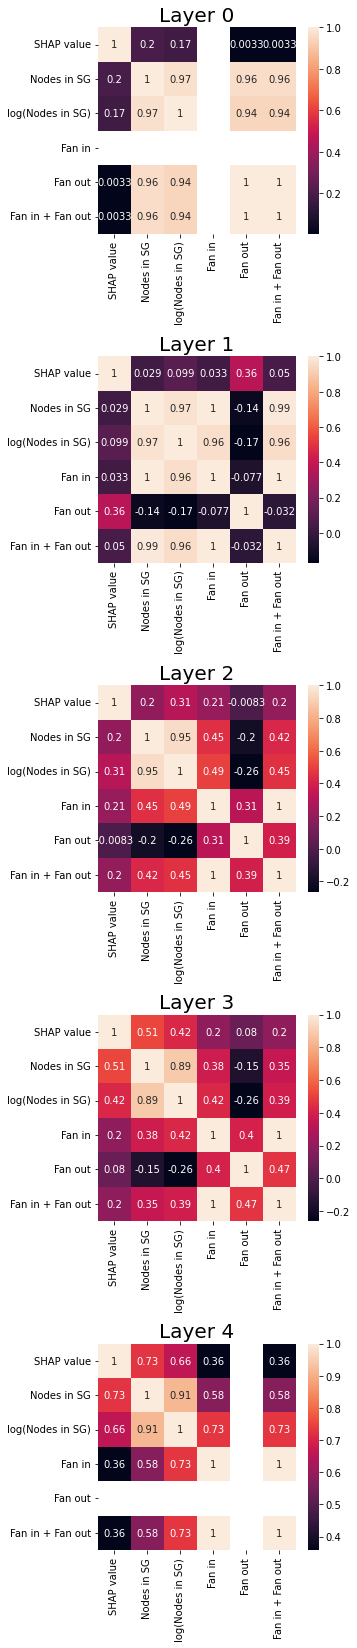

In [25]:
import seaborn as sns
fig, axs = plt.subplots(5,1, figsize=(5,23))
for i, ax in enumerate(axs.ravel()):
    p = df[df['source layer'] == i][['value', "nodes_in_SG",'log(Nodes in SG)', 'fan_in','fan_out', 'fan_tot']].corr("pearson")

    sns.heatmap(p, annot=True, ax = ax)
    ax.set_xticks([x+0.5 for x in range(6)], ['SHAP value','Nodes in SG', 'log(Nodes in SG)','Fan in', 'Fan out', 'Fan in + Fan out'])
    ax.set_yticks([x+0.5 for x in range(6)], ['SHAP value','Nodes in SG', 'log(Nodes in SG)','Fan in', 'Fan out', 'Fan in + Fan out'])
    ax.set_title(f'Layer {i}', size=20)

plt.tight_layout()
plt.savefig(f'../../plots/manuscript/{data}CorrelationWithGraphInformed.eps', bbox_inches="tight")

In [8]:
df.to_csv(f'../../plots/manuscript/network/{data}_processed.csv')

In [10]:
g = df.groupby("source", as_index=False).mean()
print(g[g["source layer"] == 0].sort_values("value", ascending=False)["source"].unique()[0:20].tolist())
print(g[g["source layer"] == 0].sort_values("weighted_val_log", ascending=False)["source"].unique()[0:20].tolist())


['APOB', 'CD14', 'CALR', 'ACTB', 'FA10', 'CO1A1', 'APOA1', 'KNG1', 'APOA4', 'THRB', 'HSP7C', 'HBB', 'OSTP', 'ANT3', 'HV323', 'TBB1', 'CATZ', 'CSPG2', 'HV353', 'HS90B']
['APOB', 'CD14', 'CALR', 'FA10', 'KNG1', 'APOA4', 'CO1A1', 'APOA1', 'ANT3', 'OSTP', 'THRB', 'ACTB', 'HBB', 'RNAS1', 'HSP7C', 'ITIH2', 'CATZ', 'CSPG2', 'ADH1A', 'GOLM1']


In [19]:

from ShapExplainerUtil import shap_sankey, complete_shap_sankey
import pandas as pd


data = "sepsis"
filepath = f'../../plots/manuscript/network/{data}_processed.csv'
df = pd.read_csv(filepath)
complete_shap_sankey(df, val_col='weighted_val_log', savename=f'../../plots/manuscript/network/{data}_processed_SANKEY.png')

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/erikh/master-thesis/src/reactome/ShapExplainerUtil.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Not found:  Cargo recognition for clathrin-mediated endocytosis
Not found:  Chaperone Mediated Autophagy
Not found:  CALR
Not found:  Post-translational protein phosphorylation
Not found:  Infectious disease
Not found:  Scavenging by Class F Receptors
Not found:  ANT3
Not found:  FA10
Not found:  Sensory Perception
Not found:  Autophagy
Not found:  KNG1
Not found:  Signaling by PDGF
Not found:  Chaperone Mediated Autophagy
Not found:  Response to elevated platelet cytosolic Ca2+
Not found:  Signaling by PDGF
Not found:  Scavenging by Class F Receptors
Not found:  Post-translational protein phosphorylation
Not found:  Visual phototransduction
Not found:  Clathrin-mediated endocytosis
